In [140]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import coo_matrix

Read the data

In [2]:
prot_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_protein_filter.csv"
rna_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_rna_raw.csv"

gene_map = {
    "CD11c": "Itgax",
    "CD27" : "Cd27",
    "CD8a" : "Cd8a",
    "CD68" : "Cd68",
    "2" : "Thy1",
    "CD3" : "Cd3g",
    "CD44" : "Cd44",
    "CD5" : "Cd5",
    "CD4" : "Cd4",
    "CD29" : "Itgb1"
}

In [3]:
prot_data = pd.read_csv(prot_data_path)
rna_data = pd.read_csv(rna_data_path)

In [5]:
prot_data.columns = prot_data.columns.str.split("_").str[-1]
# rename the columns of the prot_data based on the gene_map
prot_data.rename(columns=gene_map, inplace=True)

# using the data in prot_data replace the columns in rna_data
rna_data.index = rna_data["Unnamed: 0"]
rna_data.drop("Unnamed: 0", axis=1, inplace=True)
prot_data.index = prot_data["Unnamed: 0"]
prot_data.drop("Unnamed: 0", axis=1, inplace=True)

# rna_coords
rna_coords = np.asarray(rna_data.index.str.split("_", expand=True))
rna_coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in rna_coords])

# prot_coords
prot_coords = np.asarray(prot_data.index.str.split("_", expand=True))
prot_coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in prot_coords])

Replace the corresponding rna expression with protein expression

In [17]:
def align_prot_rna_mtx(df, gene_name):
    data = df[gene_name]
    coords = np.asarray(data.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    # delete the data with coordination[1] less than 13
    x_mask_ind = coordination[:, 0] >= 13
    y_mask_ind = coordination[:, 1] <= 78
    mask_ind = x_mask_ind & y_mask_ind
    data = data[mask_ind]
    coordination = coordination[mask_ind]
    row_ind = coordination[:, 0] - 13
    col_ind = coordination[:, 1]
    data = data.values
    coo = coo_matrix((data, (row_ind, col_ind)), shape=np.max(coordination, axis=0)+1)
    csr = coo.tocsr()
    plt.scatter(row_ind, col_ind, c=data, cmap="inferno", s=2)
    plt.title(f"{gene_name} spatial expression")
    plt.colorbar()
    plt.show()
    return csr

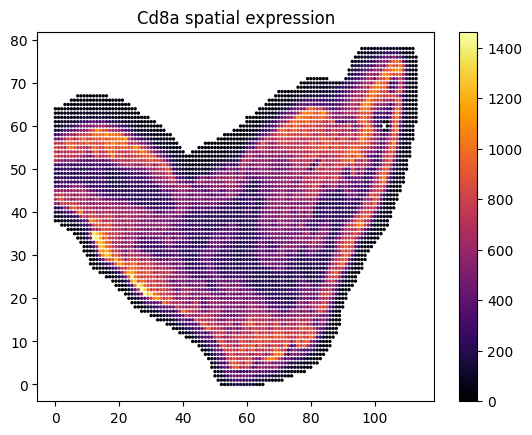

In [18]:
csr_mtx = align_prot_rna_mtx(prot_data, "Cd8a")

In [96]:
# convert the csr_mtx to a df with only one column named "Cd8a", and the index is the coordination "x_y"
def csr2df(csr_mtx, gene_name):
    # make sure the csr_mtx has no zero value
    csr_mtx.eliminate_zeros()
    data = csr_mtx.data
    # get the coordination of the data
    ind_list = csr_mtx.nonzero()[0].tolist()
    col_list = csr_mtx.nonzero()[1].tolist()
    coord_list = [f"{ind}_{col}" for ind, col in zip(ind_list, col_list)]
    # convert it to a df
    df = pd.DataFrame(data, index=coord_list, columns=[gene_name])
    return df

In [97]:
csr_df = csr2df(csr_mtx, "Cd8a")

In [100]:
rna_data.index.name = None
# replace the "Cd8a" column in rna_data with the "Cd8a" column in csr_df
rna_data["Cd8a"] = csr_df["Cd8a"]

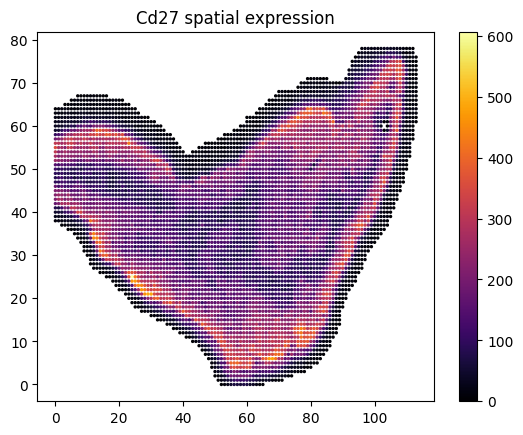

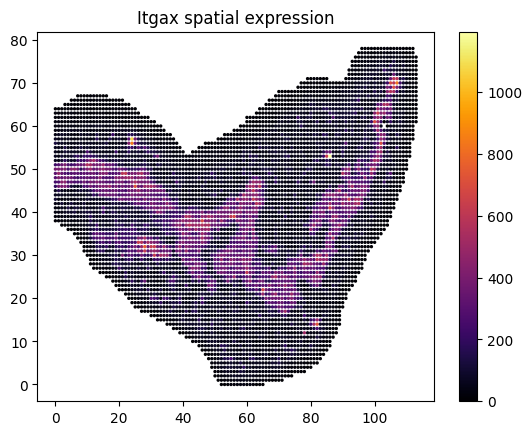

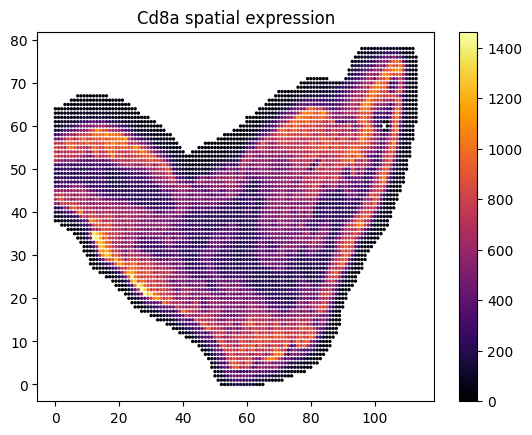

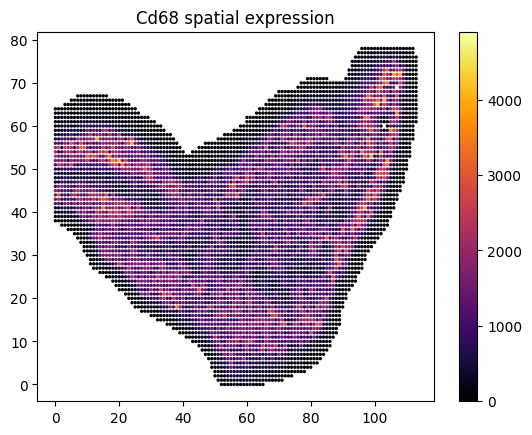

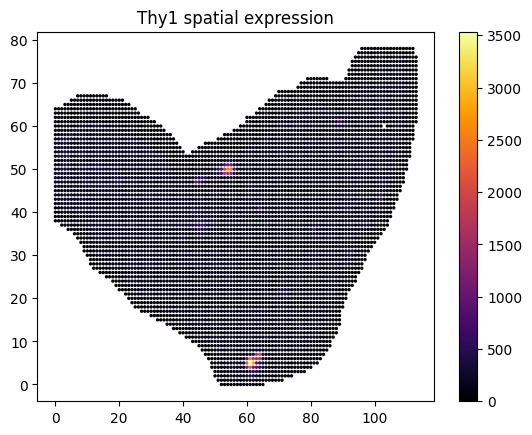

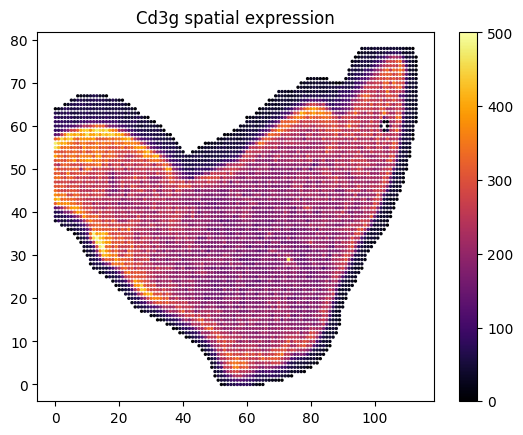

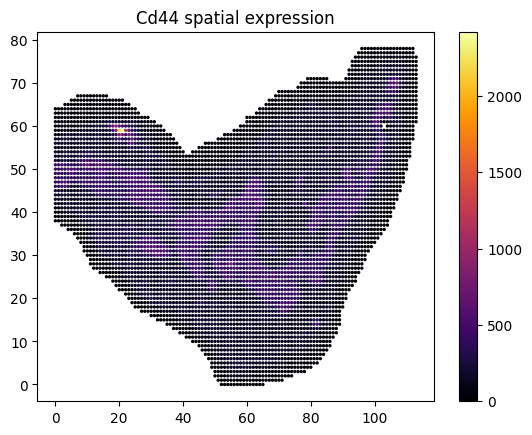

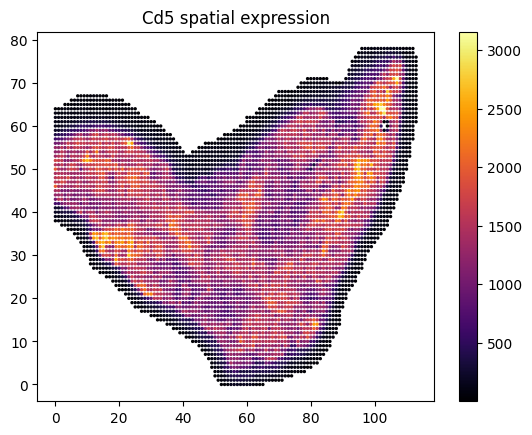

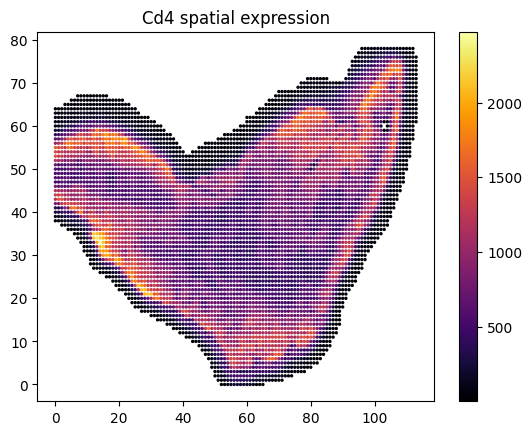

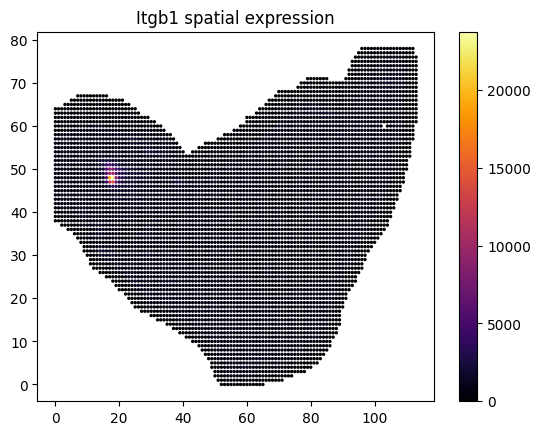

In [103]:
# for each column of the prot_data, replace the corresponding column in rna_data
for gene_name in prot_data.columns:
    csr_mtx = align_prot_rna_mtx(prot_data, gene_name)
    csr_df = csr2df(csr_mtx, gene_name)
    rna_data[gene_name] = csr_df[gene_name]

In [108]:
# save the rna_data to "prot_rep_rna_in_raw.csv"
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/prot_rep_rna_in_raw.csv"
rna_data.index.name = "coordination"
rna_data.to_csv(fuzed_data_path, index=True)

Use the replaced rna expression to do the analysis

In [111]:
# create anndata through the rna_data
adata = sc.AnnData(rna_data)

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


In [124]:
coordination = np.asarray([coord.split("_") for coord in adata.obs.index])
coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coordination])
adata.obsm["spatial"] = coordination

In [138]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [139]:
adata

AnnData object with n_obs × n_vars = 5592 × 25818
    obs: 'n_counts', 'clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/tmp/ipykernel_1163604/1125004840.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/tmp/ipykernel_1163604/1125004840.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bi

<AxesSubplot: xlabel='n_genes_by_counts'>

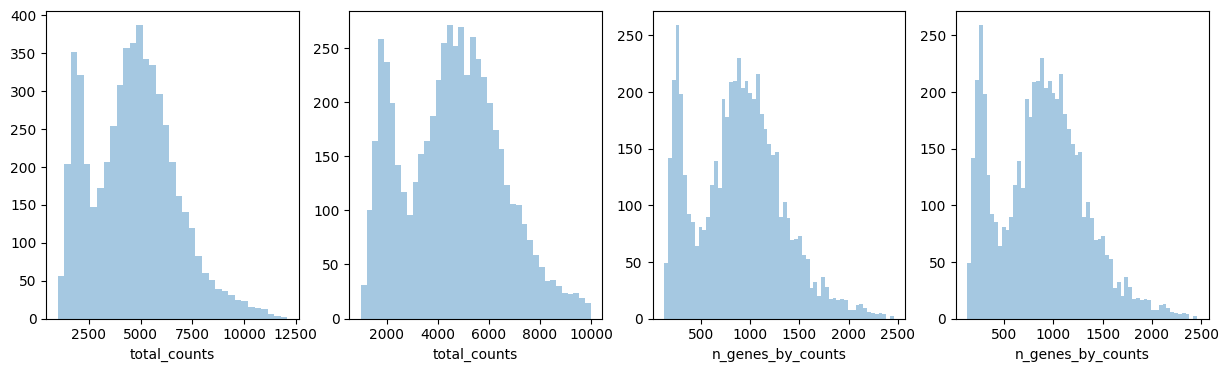

In [141]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [142]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", resolution=0.7)

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [144]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


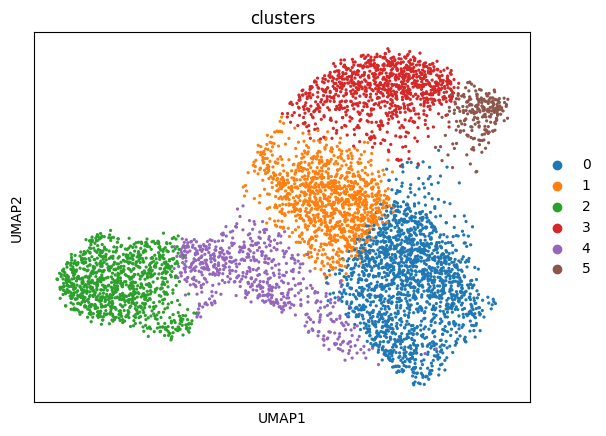

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


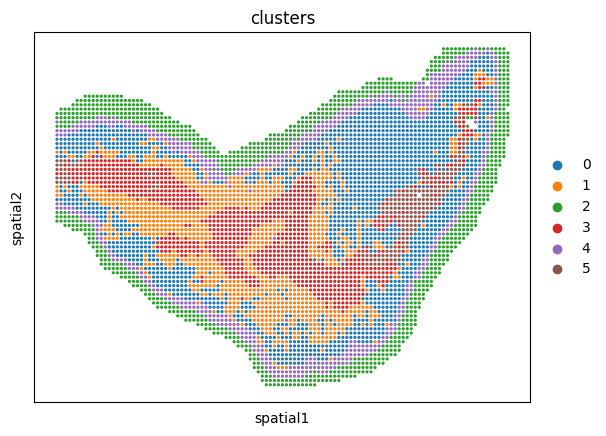

In [143]:
sc.pl.umap(adata, color="clusters")
sc.pl.embedding(adata, basis="spatial", color="clusters")

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


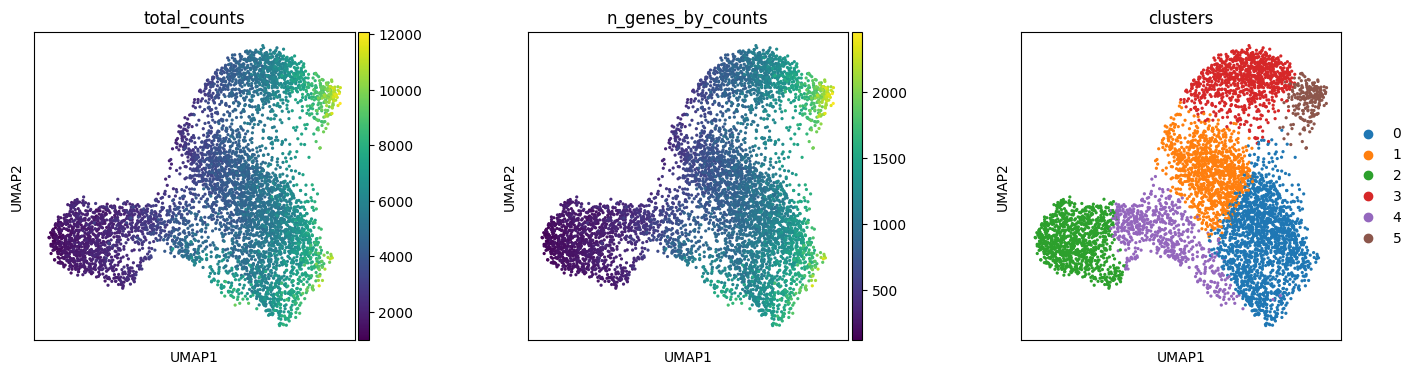

In [145]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


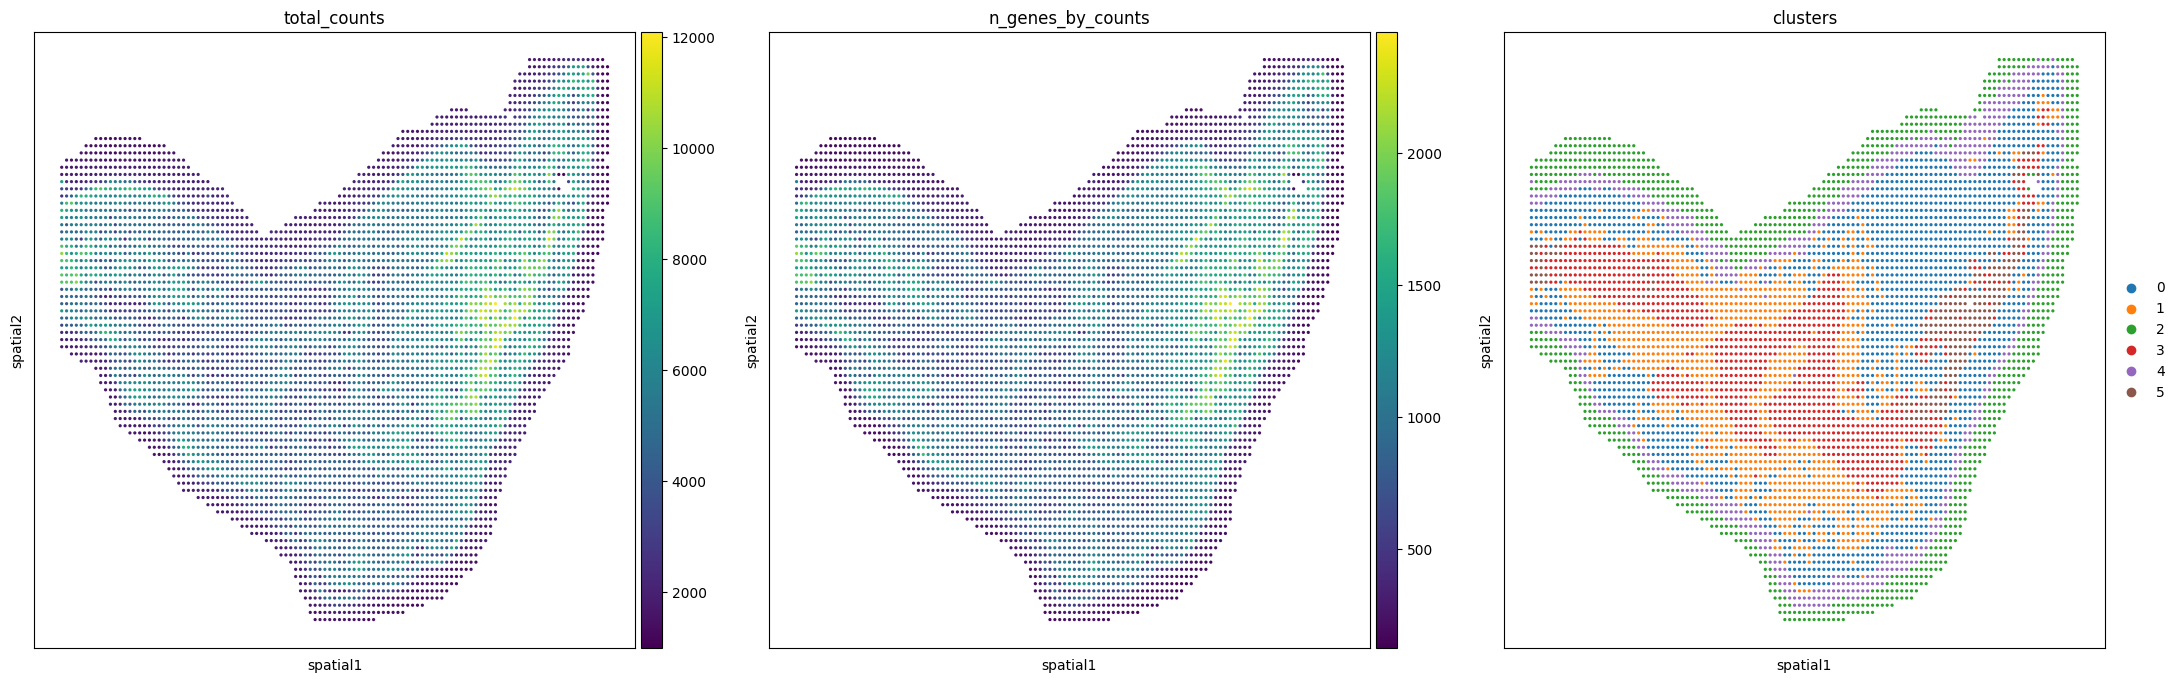

In [151]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.embedding(adata, basis="spatial", 
                color=["total_counts", "n_genes_by_counts", "clusters"])

categories: 0, 1, 2, etc.
var_group_labels: 3


/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


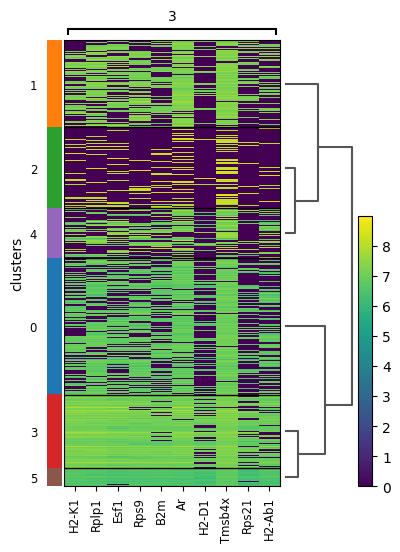

In [152]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="3", n_genes=10, groupby="clusters")

In [ ]:
# not used
# Test the indices of csr_matrix
# Get the row and col index of the csr_mtx data
data_lst = []
for i in range(csr_mtx.indptr.shape[0]-1):
    row_ind = i
    row_data_lst = []
    col_ind = csr_mtx.indices[csr_mtx.indptr[i]:csr_mtx.indptr[i+1]]
    data = csr_mtx.data[csr_mtx.indptr[i]:csr_mtx.indptr[i+1]]
    for j in range(col_ind.shape[0]):
        row_data_lst.append((row_ind, col_ind[j], data[j]))
    data_lst.append(row_data_lst)
print(data_lst[0])
print(csr_mtx)